In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

import dpkt
import numpy as np
import time
import brewer2mpl
import AttackAnalysis

reload(AttackAnalysis)
from AttackAnalysis import compute_effective_rate, compute_sending_rate, compute_all_rates
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

In [6]:
host_to_ip, ip_to_host = ReadHosts('experiment_oak.conf')
interval = 5
root_dir = 'workdir/results-experiment5_2/'
figures_dir = 'paper-plots/exp5_2/'

In [7]:
# sizes = ['size1', 'size2', 'size3', 'size4', 'size5', 'size6', 'size7', 'size8', 'size9', 'size10']
rates = ['50', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000']
attacker_list = ['attacknode-1', 'attacknode-2', 'attacknode-3', 'attacknode-4', 'attacknode-5']
attacker_set = set((host_to_ip['attacknode-1'], host_to_ip['attacknode-2'], 
                    host_to_ip['attacknode-3'], host_to_ip['attacknode-4'], host_to_ip['attacknode-5']))

attacker_interval = 5

In [8]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [9]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [10]:
def compute_everything(prefix='results-exp5_2_rate_', capfile='servernode-log_agent-tcpdump.cap',
                       verbose=False, postfix=[''], shost='servernode'):
    throughput = {}
    for post in postfix:
        filename = root_dir + prefix + post
        print "Generating throughput for %s" % filename
        filename += '/' + capfile

        start_time = time.time()
        throughput[post] = compute_global_throughput(filename, interval, host_to_ip[shost])
        end_time = time.time()
        if verbose:
            print "Time taken is ", end_time - start_time
            
    return throughput

In [11]:
def plot_throughput_overimpose(in_throughput, in_host_to_ip, postfix=[], 
                               host=['clientnode-1'], yincr=[5,50], ylimincr=[5,50], 
                               plt_title=['Client','Server'], ystart=[-1,-10]):
    
    fig = plt.figure()#figsize=(10,10))
    k = 1
    
    for host_entry in host:
        host_ip = in_host_to_ip[host_entry]
        ax = fig.add_subplot(1,2,k)
        
        plotnum = 0
        for post in postfix:
            maxbps = 0
            
            th = in_throughput[post]
            host_th = th[host_ip]

            host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)
            
            ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                    label=post, linewidth=2, color=colors[plotnum])
            plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        plt.title(plt_title[k-1])
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart[k-1], maxbps+ylimincr[k-1])
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr[k-1],yincr[k-1])
        ax.set_yticks(yrange)

        #if k%2==0:
        #    ax.set_yticklabels([])  
        if not k%2==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

    if len(fig.axes)%2 == 0:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]
    
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
 
    #plt.savefig('paper-plots/throughput-exp2-2.pdf', bbox_inches = 'tight')
    #plt.show()

In [12]:
def plot_next_to_each_other(in_throughput, in_host_to_ip, postfix=[], host='clientnode-1',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1):
    fig = plt.figure()
    plotnum = 1
    
    num_subplots = len(postfix)
    if num_subplots == 0:
        print "[ERROR:] Empty input postfix array!"
        return 
    
    host_ip = in_host_to_ip[host]
    
    # put three plots next to each other
    num_rows = num_subplots / 3
    if num_subplots % 3 > 0:
        num_rows += 1
    
    k = 0
    for post in postfix:
        maxbps = 0
    
        ax = fig.add_subplot(num_rows,3,plotnum)
        th = in_throughput[post]
        host_th = th[host_ip]

        host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)

        ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                label=post, linewidth=2, color=colors[coloridx])
        plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart, maxbps+ylimincr)
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr,yincr)
        ax.set_yticks(yrange)

#         if k%3==0:
#             ax.set_yticklabels([])  
        if k%3==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)
        
        # draw the average line
        ax.axhline(np.mean(host_bps[24:96]), linestyle='--', linewidth=2, xmin=.2, xmax=.8)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

#     if num_subplots%3 == 0:
#         ax = fig.axes[-3]
#     elif num_subplots%3 == 2:
#         ax = fig.axes[-2]
#     elif num_subplots%3 == 1:
#         ax = fig.axes[-1]
    
#     legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
#     frame = legend.get_frame()
#     frame.set_facecolor('1')
#     frame.set_edgecolor('0.75')

# Attack Analysis from Server Side

In [13]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('Set2', 'qualitative', 5)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [14]:
attack_rates = {}

for rate in rates:
    server_file_template = 'servernode-log_agent-tcpdump.cap'
        
    cap_file = root_dir + 'results-exp5_2_rate_' + rate + '/' + server_file_template
    print "-----> Using cap file: %s" % cap_file
        
    syn_rates, connection_rates = compute_all_rates(cap_file, attacker_interval, attacker_set, 1)    
    attack_rates[rate] = (syn_rates, connection_rates)

-----> Using cap file: workdir/results-experiment5_2/results-exp5_2_rate_50/servernode-log_agent-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	4266
Total number of acked connections:     	112
Total number of failed connections:    	4047
Total number of replies received:      	4159
Average SYN rate seen by server:       	12.7969230769
Average ACK rate seen by server:       	0.344615384615
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	4787
Total number of acked connections:     	488
Total number of failed connections:    	3904
Total number of replies received:      	4385
Average SYN rate seen by server:       	11.1189873418
Average ACK rate seen by server:       	1.23544303797
+-------------------------------------------

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	13169
Total number of acked connections:     	156
Total number of failed connections:    	12681
Total number of replies received:      	12819
Average SYN rate seen by server:       	35.1698630137
Average ACK rate seen by server:       	0.427397260274
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	17674
Total number of acked connections:     	355
Total number of failed connections:    	14120
Total number of replies received:      	14448
Average SYN rate seen by server:       	40.2083333333
Average ACK rate seen by server:       	1.0
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of at

-----> Using cap file: workdir/results-experiment5_2/results-exp5_2_rate_800/servernode-log_agent-tcpdump.cap
[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	12900
Total number of acked connections:     	150
Total number of failed connections:    	12441
Total number of replies received:      	12529
Average SYN rate seen by server:       	34.495890411
Average ACK rate seen by server:       	0.416666666667
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	21462
Total number of acked connections:     	589
Total number of failed connections:    	17703
Total number of replies received:      	18191
Average SYN rate seen by server:       	50.1150684932
Average ACK rate seen by server:       	1.68285714286
+-------------------------------------

In [15]:
ab = compute_all_rates(
    '/data/ddos-oakland/workdir/results-nping/results-nping-nodefense/servernode-log_agent-tcpdump.cap', 
    attacker_interval, attacker_set, 1)

[WARNING:] Packets in cap file are out of order.
+----------------------------------------------------+
Statistics for host 10.1.4.3
Total number of attempted connections: 	2701
Total number of acked connections:     	2680
Total number of failed connections:    	3
Total number of replies received:      	2680
Average SYN rate seen by server:       	4.47166666667
Average ACK rate seen by server:       	4.46666666667
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.4
Total number of attempted connections: 	2673
Total number of acked connections:     	2652
Total number of failed connections:    	3
Total number of replies received:      	2652
Average SYN rate seen by server:       	4.425
Average ACK rate seen by server:       	4.42
+----------------------------------------------------+
+----------------------------------------------------+
Statistics for host 10.1.4.5
Total number of attempted connection

# Attack Impact Analysis

In [16]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('Set2', 'qualitative', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [17]:
%%capture
attack_rates = {}

for rate in rates:
    attack_rates[rate] = {}
    for attacker in attacker_list:
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        attacker_ip = host_to_ip[attacker]
        
        cap_file = root_dir + 'results-exp5_2_rate_' + rate + '/' + attack_file_template
        # cap_file = '/data/ddos-oakland/workdir/results-nping/results-nping-nodefense/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_effective_rate(cap_file, attacker_interval, False)    
        entry = effective_rate[attacker_ip]
        attack_rates[rate][attacker_ip] = entry

In [23]:
%%capture
sending_rates = {}

for rate in rates:
    sending_rates[rate] = {}
    for attacker in attacker_list:
        attack_file_template = attacker + '-attack_log-tcpdump.cap'
        attacker_ip = host_to_ip[attacker]
        
        cap_file = root_dir + 'results-exp5_2_rate_' + rate + '/' + attack_file_template
        # cap_file = '/data/ddos-oakland/workdir/results-nping/results-nping-nodefense/' + attack_file_template
        print "-----> Using cap file: %s" % cap_file
        
        effective_rate = compute_sending_rate(cap_file, attacker_interval, attacker_ip, 0)    
        sending_rates[rate][attacker_ip] = effective_rate

In [24]:
numerical_rates = [50,100,200,300,400,500,600,700,800,900,1000]

full_rates = {}
full_ack_rates = {}
for rate in rates:
    flatten_rates = None
    ack_rates = None
    for attacker in attacker_set:
        local_rate = sending_rates[rate][attacker]
        if (flatten_rates is None):
            flatten_rates = local_rate
        else:
            flen = len(flatten_rates)
            rlen = len(local_rate)
            
            padded_rate = local_rate
            if flen > rlen:
                padded_rate = np.pad(local_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                flatten_rates =  np.pad(flatten_rates, (0, rlen-flen), 'constant')
            assert (len(flatten_rates) == len(padded_rate))
            flatten_rates = flatten_rates + padded_rate
        
        local_ack_rate = attack_rates[rate][attacker]
        if (ack_rates is None):
            ack_rates = local_ack_rate
        else:
            flen = len(ack_rates)
            rlen = len(local_ack_rate)
            
            padded_ack_rate = local_ack_rate
            if flen > rlen:
                padded_ack_rate = np.pad(local_ack_rate, (0, flen-rlen), 'constant')
            elif rlen > flen:
                ack_rates = np.pad(ack_rates, (0,rlen-flen), 'constant')
            assert(len(ack_rates) == len(padded_ack_rate))
            ack_rates = ack_rates + padded_ack_rate
            
    full_rates[rate] = flatten_rates
    full_ack_rates[rate] = ack_rates

# get the stuff for the sending rates
avg_rates = np.array([0]*len(numerical_rates))
err_bars = np.array([0]*len(numerical_rates))
i=0
for rate in rates:
    avg_rates[i] = np.mean(full_rates[rate])
    err_bars[i] = stats.sem(full_rates[rate])
    i += 1

# now do the same for the ack rates
avg_ack_rates = np.array([0]*len(numerical_rates))
err_ack_bars = np.array([0]*len(numerical_rates))
i=0
for rate in rates:
    avg_ack_rates[i] = np.mean(full_ack_rates[rate])
    err_ack_bars[i] = stats.sem(full_ack_rates[rate])
    i += 1

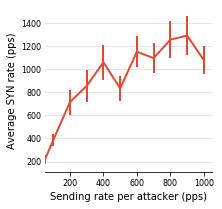

In [25]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [3,3]
   }
plt.rcParams.update(params)

figpath = figures_dir + 'syn_rate.pdf'

fig = plt.figure()
# now plot the stuff
ax = fig.add_subplot(1,1,1)
ax.errorbar(numerical_rates,  avg_rates, yerr=err_bars, linewidth=2, color=colors[-1])
ax.set_xlabel('Sending rate per attacker (pps)')
ax.set_ylabel('Average SYN rate (pps)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax.set_xlim(50,1050)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', length=0)

#plt.savefig(figpath, bbox_inches = 'tight')

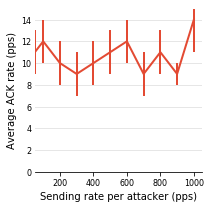

In [26]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [3,3]
   }
plt.rcParams.update(params)

fig = plt.figure()
figpath = figures_dir + 'ack_rate.pdf'

ax2 = fig.add_subplot(1,1,1)
ax2.errorbar(numerical_rates, avg_ack_rates, yerr=err_ack_bars, linewidth=2, color=colors[-1])
ax2.set_xlabel('Sending rate per attacker (pps)')
ax2.set_ylabel('Average ACK rate (pps)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax2.set_xlim(50,1050)
ax2.set_ylim(0,15)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis='x', direction='out')
ax2.tick_params(axis='y', length=0)

#plt.savefig(figpath, bbox_inches = 'tight')

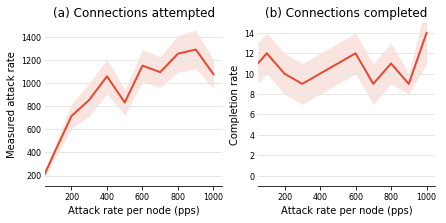

In [57]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 10,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [7,3]
   }
plt.rcParams.update(params)

figpath = figures_dir + 'combined.pdf'

fig = plt.figure()
# now plot the stuff
ax = fig.add_subplot(1,2,1)
ax.plot(numerical_rates,  avg_rates, linewidth=2, color=colors[-1])

high=[]
low=[]
for val, err in zip(avg_rates, err_bars):
    high.append(val+err)
    low.append(val-err)

ax.fill_between(numerical_rates, high, low, alpha=0.15, linewidth=0, color=colors[-1])


ax.set_xlabel('Attack rate per node (pps)')
ax.set_ylabel('Measured attack rate')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax.set_xlim(50,1050)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', length=0)
ax.set_title('(a) Connections attempted')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(numerical_rates, avg_ack_rates, linewidth=2, color=colors[-1])
high=[]
low=[]
for val, err in zip(avg_ack_rates, err_ack_bars):
    high.append(val+err)
    low.append(val-err)

ax2.fill_between(numerical_rates, high, low, alpha=0.15, linewidth=0, color=colors[-1])


ax2.set_xlabel('Attack rate per node (pps)')
ax2.set_ylabel('Completion rate')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
ax2.set_xlim(50,1050)
ax2.set_ylim(-1,15)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()
ax2.tick_params(axis='x', direction='out')
ax2.tick_params(axis='y', length=0)
ax2.set_title('(b) Connections completed')

plt.savefig(figpath, bbox_inches = 'tight')

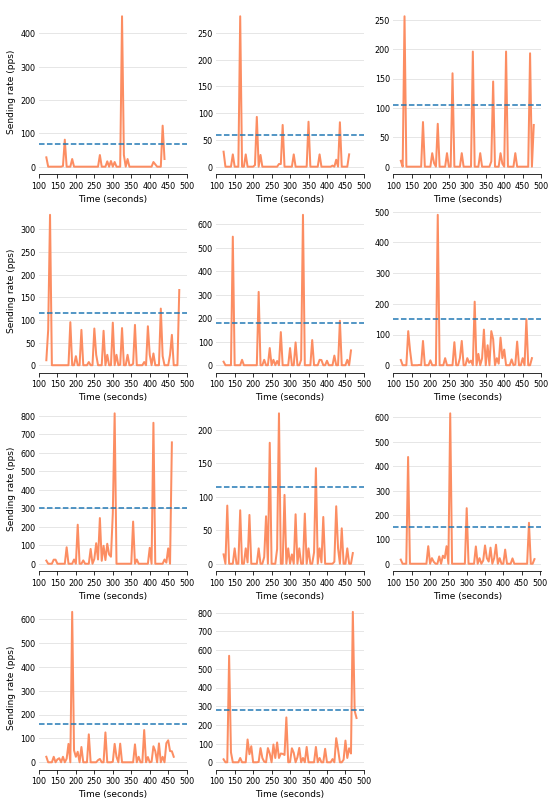

In [37]:
fig = plt.figure()
plotnum = 1

num_subplots = len(rates)

host_ip = host_to_ip['attacknode-1']

# put three plots next to each other
num_rows = num_subplots / 3
if num_subplots % 3 > 0:
    num_rows += 1

k = 0
for rate in rates:
    maxbps = 0

    ax = fig.add_subplot(num_rows,3,plotnum)
    s_rate = sending_rates[rate][host_ip]
    num_buckets = len(s_rate)
    buckets = np.arange(120, 120+num_buckets * attacker_interval, attacker_interval)
    
    ax.plot(buckets, s_rate/attacker_interval, marker=None, markerfacecolor='none', 
            label=rate, linewidth=2, color=colors[1])
    plotnum += 1

    #maxbps = np.maximum(maxbps, np.max(host_bps))

    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    #ax.set_ylim(ystart, maxbps+ylimincr)
    ax.set_xticks([100,150,200,250,300,350,400,450,500])
    #ax.set_xlim(0,599)

    # set y ticks
    #yrange = np.arange (0,maxbps+ylimincr,yincr)
    #ax.set_yticks(yrange)

#         if k%3==0:
#             ax.set_yticklabels([])  
    if k%3==0:
        ax.set_ylabel('Sending rate (pps)')

    ax.set_xlabel('Time (seconds)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x', direction='out')
    ax.tick_params(axis='y', length=0)
    ax.set_axisbelow(True)

    # draw the average line
    ax.axhline(np.mean(s_rate), linestyle='--')
    #ax.axhline(np.mean(host_bps[24:96]), linestyle='--', linewidth=2, xmin=.2, xmax=.8)

    #ax.axvspan(120,480,color='red', alpha=0.1)
    k += 1

# Client Throughput Analysis

In [13]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('Set2', 'qualitative', 5)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 14]
   }
plt.rcParams.update(params)

In [40]:
throughput = compute_everything(verbose=True, postfix=rates)

Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_50
Time to read pcap file 0.000538110733032
Time taken is  50.3094391823
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_100
Time to read pcap file 0.000217914581299
Time taken is  49.9052219391
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_200
Time to read pcap file 0.00116109848022
Time taken is  46.7394099236
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_300
Time to read pcap file 0.000221014022827
Time taken is  47.9960889816
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_400
Time to read pcap file 0.000204086303711
Time taken is  44.5940330029
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_500
Time to read pcap file 0.0002121925354
Time taken is  42.1842780113
Generating throughput for workdir/results-experiment5_2/results-exp5_2_rate_600
Time to read pcap file 0

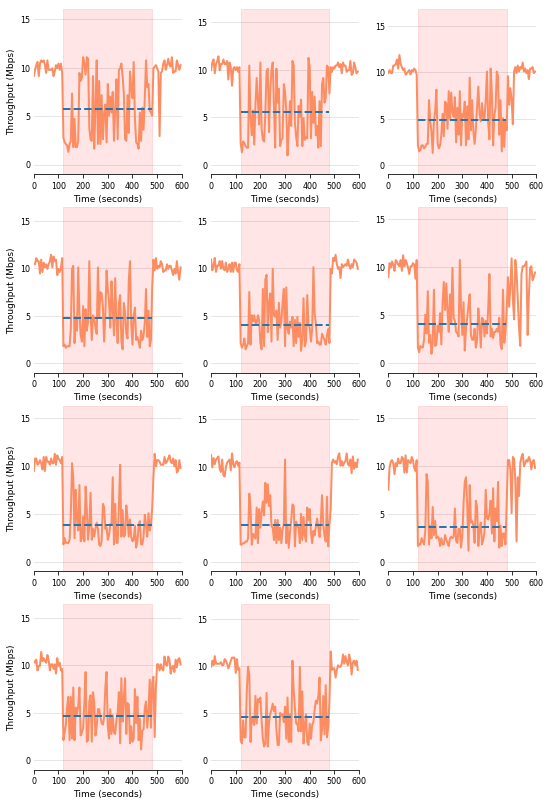

In [41]:
plot_next_to_each_other(throughput, host_to_ip, postfix=rates)

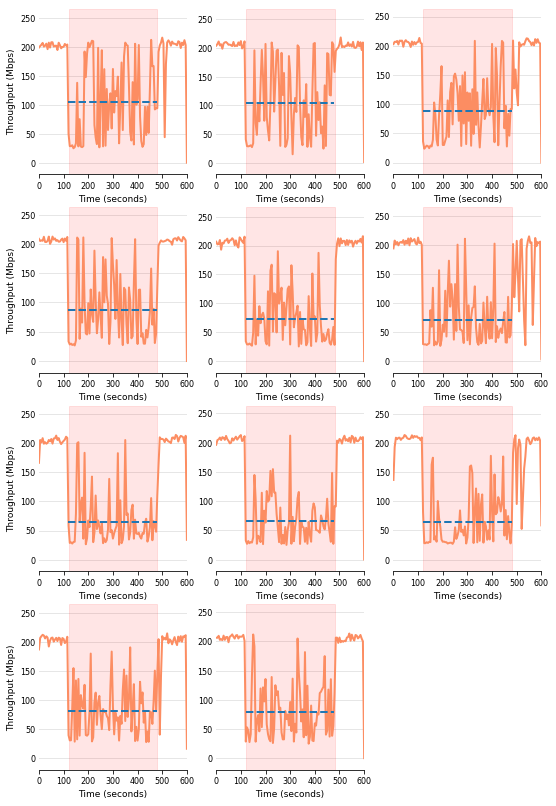

In [42]:
plot_next_to_each_other(throughput, host_to_ip, postfix=rates, host='servernode',
                       yincr=50, ylimincr=50, ystart=-20)